In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, LearningCurveDisplay, learning_curve, ValidationCurveDisplay, validation_curve
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    fbeta_score,
    classification_report,
    make_scorer
)


from utils import get_data, get_df_details, plot_distrb, make_confusion_matrix

# sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [3]:
X, y, metadata, variables = get_data('dry_bean_dataset')

In [4]:
y.value_counts(normalize=True)

Class   
DERMASON    0.260525
SIRA        0.193667
SEKER       0.148924
HOROZ       0.141650
CALI        0.119756
BARBUNYA    0.097127
BOMBAY      0.038351
Name: proportion, dtype: float64

In [5]:
# Split data into train and test sets.
# We use Stratifield sampling to ensure that the distribution of the data is maintained across the sample.
# Use stratified kfold cross validation to ensure that the model is not overfitting the data

TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

In [6]:
idx = variables['type'].isin(['Integer', 'Continuous'])
num_cols = variables.loc[idx, 'name']
num_cols = num_cols.loc[~num_cols.isin(y.columns.tolist())]
num_cols

0                Area
1           Perimeter
2     MajorAxisLength
3     MinorAxisLength
4         AspectRatio
5        Eccentricity
6          ConvexArea
7       EquivDiameter
8              Extent
9            Solidity
10          Roundness
11        Compactness
12       ShapeFactor1
13       ShapeFactor2
14       ShapeFactor3
15       ShapeFactor4
Name: name, dtype: object

In [7]:
idx = variables['type'].isin(['Binary', 'Categorical'])
cat_cols = variables.loc[idx, 'name']
cat_cols = cat_cols.loc[~cat_cols.isin(y.columns)]
cat_cols

Series([], Name: name, dtype: object)

# Train GradientBoostingClassifier

In [8]:

RANDOM_STATE = 42
N_FOLDS = 5
N_JOBS = -1
SCORING = 'accuracy'
VERBOSE = 4


# Use minmax scaler for simplicity, scalability, avoids assumption of distribution and there are no outliers in data
num_pipeline = Pipeline(steps=[
    ('scale', MinMaxScaler())
])
# cat_pipeline = Pipeline(steps=[
#     ('one-hot', OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse=False))
# ])

col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    # ('cat_pipeline', cat_pipeline, cat_cols)
    ],
    remainder='drop',
    n_jobs=N_JOBS)

clf = GradientBoostingClassifier(random_state=RANDOM_STATE)
clf_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', clf)
])



## Tune the GradientBoostingClassifier

In [9]:
cv_scores = []

grid_params = {
        'n_estimators': {'model__n_estimators': [20, 50, 75, 100, 125, 150, 200]}, 
        'learning_rate': {'model__learning_rate': np.linspace(0.1, 0.9, 9)},
    }
for key, grid_param in grid_params.items():
    print('------------------', key, '------------------')
    
    gs = GridSearchCV(clf_pipeline, grid_param, 
                      cv=N_FOLDS, scoring=SCORING, n_jobs=N_JOBS, verbose=VERBOSE, return_train_score=True)
    gs.fit(X_train, y_train.values.ravel())

    cv_scores.append(pd.DataFrame({'param': [key]*len(gs.cv_results_['mean_test_score']),
                                   'value': gs.cv_results_[f'param_{list(grid_param.keys())[0]}'],
                                   'mean_test_score': gs.cv_results_['mean_test_score'],
                                   'mean_train_score': gs.cv_results_['mean_train_score'],
                                   }))

cv_scores = pd.concat(cv_scores)

------------------ n_estimators ------------------
Fitting 5 folds for each of 7 candidates, totalling 35 fits
------------------ learning_rate ------------------
Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


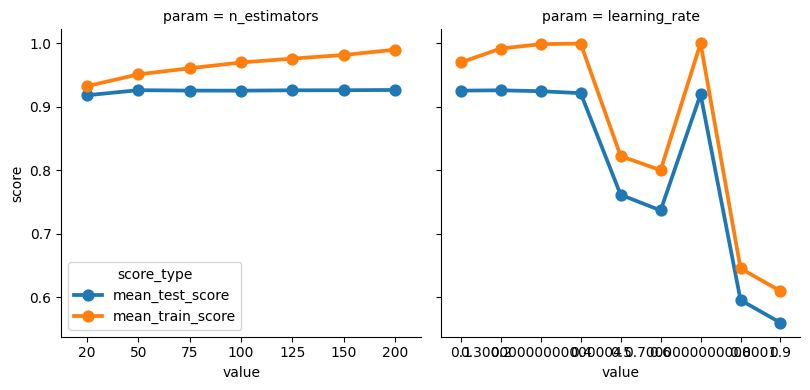

In [10]:
cv_scores_melt = cv_scores.melt(id_vars=['param', 'value'], value_vars=['mean_test_score', 'mean_train_score'], var_name='score_type', value_name='score')
sns.FacetGrid(cv_scores_melt, col='param', hue='score_type', col_wrap=3, height=4, sharex=False, legend_out=False).map(sns.pointplot, 'value', 'score').add_legend()

In [11]:
grid_params = {
        'model__n_estimators': [50, 100, 150], 
        'model__learning_rate': np.linspace(0.1, 0.5, 5)
    }

gs = GridSearchCV(clf_pipeline, grid_params, 
                    cv=N_FOLDS, scoring=SCORING, n_jobs=N_JOBS, verbose=VERBOSE, return_train_score=True)
gs.fit(X_train, y_train.values.ravel())

print("Best Score of train set: "+str(gs.best_score_))
print("Best parameter set: "+str(gs.best_params_))
print("Test Score: "+str(gs.score(X_test, y_test)))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Score of train set: 0.9259738994319525
Best parameter set: {'model__learning_rate': 0.1, 'model__n_estimators': 50}
Test Score: 0.9192067572530297


In [12]:
gs.best_estimator_['model']

GradientBoostingClassifier(n_estimators=50, random_state=42)

In [13]:
import joblib
joblib.dump(value=gs, filename='./model/boosted_dt_dry_bean_ppl.pkl', compress=True)
joblib.dump(value=gs.best_estimator_, filename='./model/boosted_dt_dry_bean_best.pkl', compress=True)

['./model/boosted_dt_dry_bean_best.pkl']

In [14]:

# Plot learning curve of the best model from grid search
train_size_abs, train_scores, test_scores = \
    learning_curve(gs.best_estimator_, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=N_FOLDS, n_jobs=N_JOBS, scoring=SCORING, verbose=VERBOSE)

[learning_curve] Training set sizes: [ 871 1742 2613 3484 4355 5226 6097 6968 7839 8710]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  50 | elapsed:   54.4s remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:  1.6min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  38 out of  50 | elapsed: 26.6min remaining:  8.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 27.2min finished


<Axes: xlabel='train_size_abs', ylabel='value'>

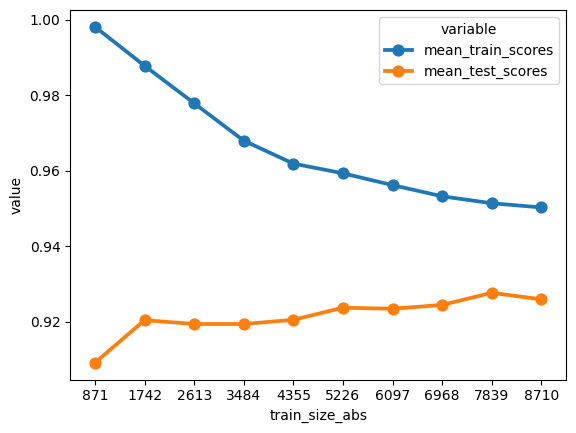

In [15]:
plot_df = pd.DataFrame({'train_size_abs': train_size_abs, 
                        'mean_train_scores': np.mean(train_scores, axis=1), 
                        'mean_test_scores': np.mean(test_scores, axis=1)})
plot_df = plot_df.melt(id_vars='train_size_abs', value_vars=['mean_train_scores', 'mean_test_scores'])
sns.pointplot(plot_df, x='train_size_abs',y ='value', hue='variable')

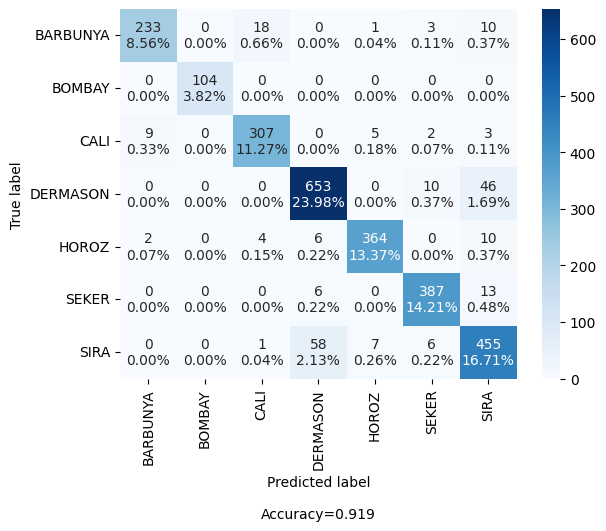

In [16]:
# Get the score of the best model on test

# gs.best_estimator_ is the best model found by GridSearchCV
y_test_predictions = gs.predict(X_test)
# Generate confusion matrix for the predictions from the best model
conf_matrix = confusion_matrix(y_test, y_test_predictions)

make_confusion_matrix(conf_matrix, group_names=['True Neg','False Pos','False Neg','True Pos'], categories=['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA'], cmap='Blues')

In [17]:

scores = {'accuracy_score':accuracy_score(y_test, y_test_predictions),
          'precision_score':precision_score(y_test, y_test_predictions),
          'recall_score':recall_score(y_test, y_test_predictions),
          'f2_score':fbeta_score(y_test, y_test_predictions, beta=2)
}

print(scores)


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [18]:

# target_names=target_names
print(classification_report(y_test, y_test_predictions))


              precision    recall  f1-score   support

    BARBUNYA       0.95      0.88      0.92       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.93      0.94      0.94       326
    DERMASON       0.90      0.92      0.91       709
       HOROZ       0.97      0.94      0.95       386
       SEKER       0.95      0.95      0.95       406
        SIRA       0.85      0.86      0.86       527

    accuracy                           0.92      2723
   macro avg       0.94      0.93      0.93      2723
weighted avg       0.92      0.92      0.92      2723



In [19]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(gs, X_test, y_test, )
plt.show()

ValueError: Expected 'estimator' to be a binary classifier. Got 7 classes instead.

In [20]:
# plot precison recall curve
import matplotlib.pyplot as plt
from sklearn.metrics import (precision_recall_curve,
                              PrecisionRecallDisplay)

precision, recall, _ = precision_recall_curve(y_test, y_test_predictions)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

ValueError: multiclass format is not supported